In [1]:
import pythetatools.toyxp as toyxp
import pythetatools.likelihood as likelihood
from pythetatools.config import *
from pythetatools.config_visualisation import *
from pythetatools.config_fc import true_param_grid_sorted

from pythetatools.base_visualisation import show_minor_ticks
from pythetatools.file_manager import read_cont
from pythetatools.feldman_cousins import get_critical_values
from collections import defaultdict


import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import uproot
import matplotlib.colors as colors
from matplotlib.ticker import LogLocator, NullFormatter
import pandas as pd

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.style.use(t2k_style)

%load_ext autoreload
%autoreload 2

Welcome to JupyROOT 6.28/04


In [2]:
param = 'delta'
prefix = 'DataFit'
mode=0
dir_ver = 'OA2023'
mode_to_prefix = {0: '', 1: 'statonly'}

def get_basename_dir(param, mode, prefix):
    basename_directory = f"MargTemplates_{prefix}_{param}_100k_p-theta_mode_{mode}"
    return basename_directory

outdir_path = f'{outputs_dir}/plots/{dir_ver}/dchi2'
os.makedirs(outdir_path, exist_ok=True)

# Compare different plots

# Stat-only vs stat+syst

In [3]:
param_flattened = 'sin223'
prefix = 'DataFit'
dim = 1
smear_factor = 3.3e-5
smeared = False

mode = 0
basename_directory = get_basename_dir(param_flattened, mode, prefix)
indir = f"{inputs_dir}/{dir_ver}/MargTemplates/{basename_directory}"
grid, avnllh, param_names = likelihood.load_from_cont(indir, smeared, smear_factor)
grid, param_names = likelihood.transform_s2213_to_sin213(grid, param_names)
llh = likelihood.Loglikelihood(grid, avnllh, param_names, mo_treat='joint')  

mode = 1
basename_directory = get_basename_dir(param_flattened, mode, prefix)
indir = f"{inputs_dir}/{dir_ver}/MargTemplates/{basename_directory}"
grid, avnllh, param_names = likelihood.load_from_cont(indir, smeared, smear_factor)
grid, param_names = likelihood.transform_s2213_to_sin213(grid, param_names)
llh_statonly = likelihood.Loglikelihood(grid, avnllh, param_names, mo_treat='joint')    

Tranformation will not be done as in your param_name there is not sin2213
Tranformation will not be done as in your param_name there is not sin2213


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


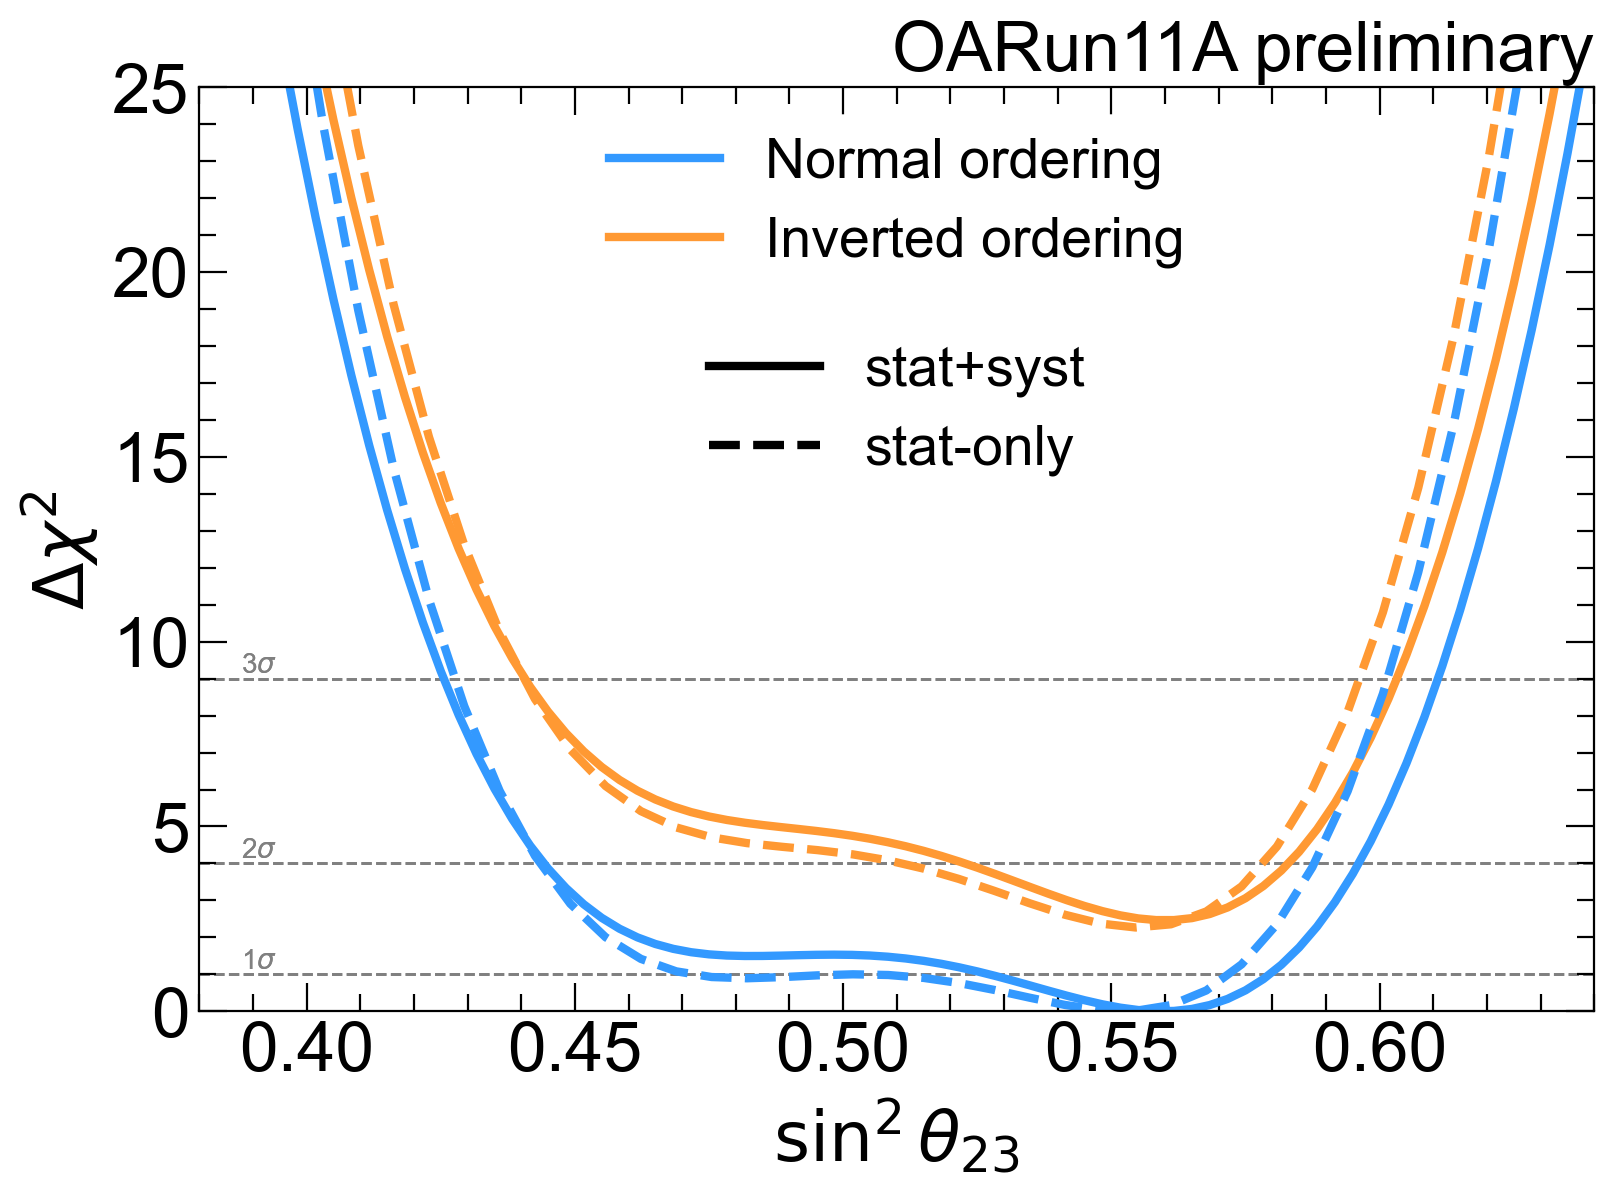

In [4]:
kwargs = {'ax.plot': {0: {'ls': '--'},
                      1: {'ls': '--'}}}

fig, ax = plt.subplots()
llh.plot(ax, wtag=True)
llh_statonly.plot(ax, wtag=True, show_legend=False, **kwargs)
param_name_x = llh.param_name[0]

line1, = ax.plot([], [], ls='-', label='stat+syst', color='black')
line2, = ax.plot([], [], ls='--', label='stat-only', color='black')

ax.legend(handles=[line1, line2], loc='center', bbox_to_anchor=(0.5, 0.65))

fig.savefig(f"{outdir_path}/dchi2_{param_flattened}_main_{prefix}_syst_vs_stat.eps", bbox_inches='tight')
fig.savefig(f"{outdir_path}/dchi2_{param_flattened}_main_{prefix}_syst_vs_stat.pdf", bbox_inches='tight')
fig.savefig(f"{outdir_path}/dchi2_{param_flattened}_main_{prefix}_syst_vs_stat.png", bbox_inches='tight', dpi=300)
fig.savefig(f"{outdir_path}/dchi2_{param_flattened}_main_{prefix}_syst_vs_stat.svg", bbox_inches='tight')


# 2D comparisons. AsimovBF vs Data-fit

In [5]:
param_flattened = 'sin223_delta'
dim = 2
smear_factor = 3.3e-5
smeared = False
mode = 0

prefix = 'AsimovBestFit'
basename_directory = get_basename_dir(param_flattened, mode, prefix)
indir = f"{inputs_dir}/{dir_ver}/MargTemplates/{basename_directory}"
grid, avnllh, param_names = likelihood.load_from_cont(indir, smeared, smear_factor)
grid, param_names = likelihood.transform_s2213_to_sin213(grid, param_names)
llh_bf = likelihood.Loglikelihood(grid, avnllh, param_names, mo_treat='conditional')  

prefix = 'DataFit'
basename_directory = get_basename_dir(param_flattened, mode, prefix)
indir = f"{inputs_dir}/{dir_ver}/MargTemplates/{basename_directory}"
grid, avnllh, param_names = likelihood.load_from_cont(indir, smeared, smear_factor)
grid, param_names = likelihood.transform_s2213_to_sin213(grid, param_names)
llh_df = likelihood.Loglikelihood(grid, avnllh, param_names, mo_treat='conditional') 


Tranformation will not be done as in your param_name there is not sin2213
Tranformation will not be done as in your param_name there is not sin2213


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


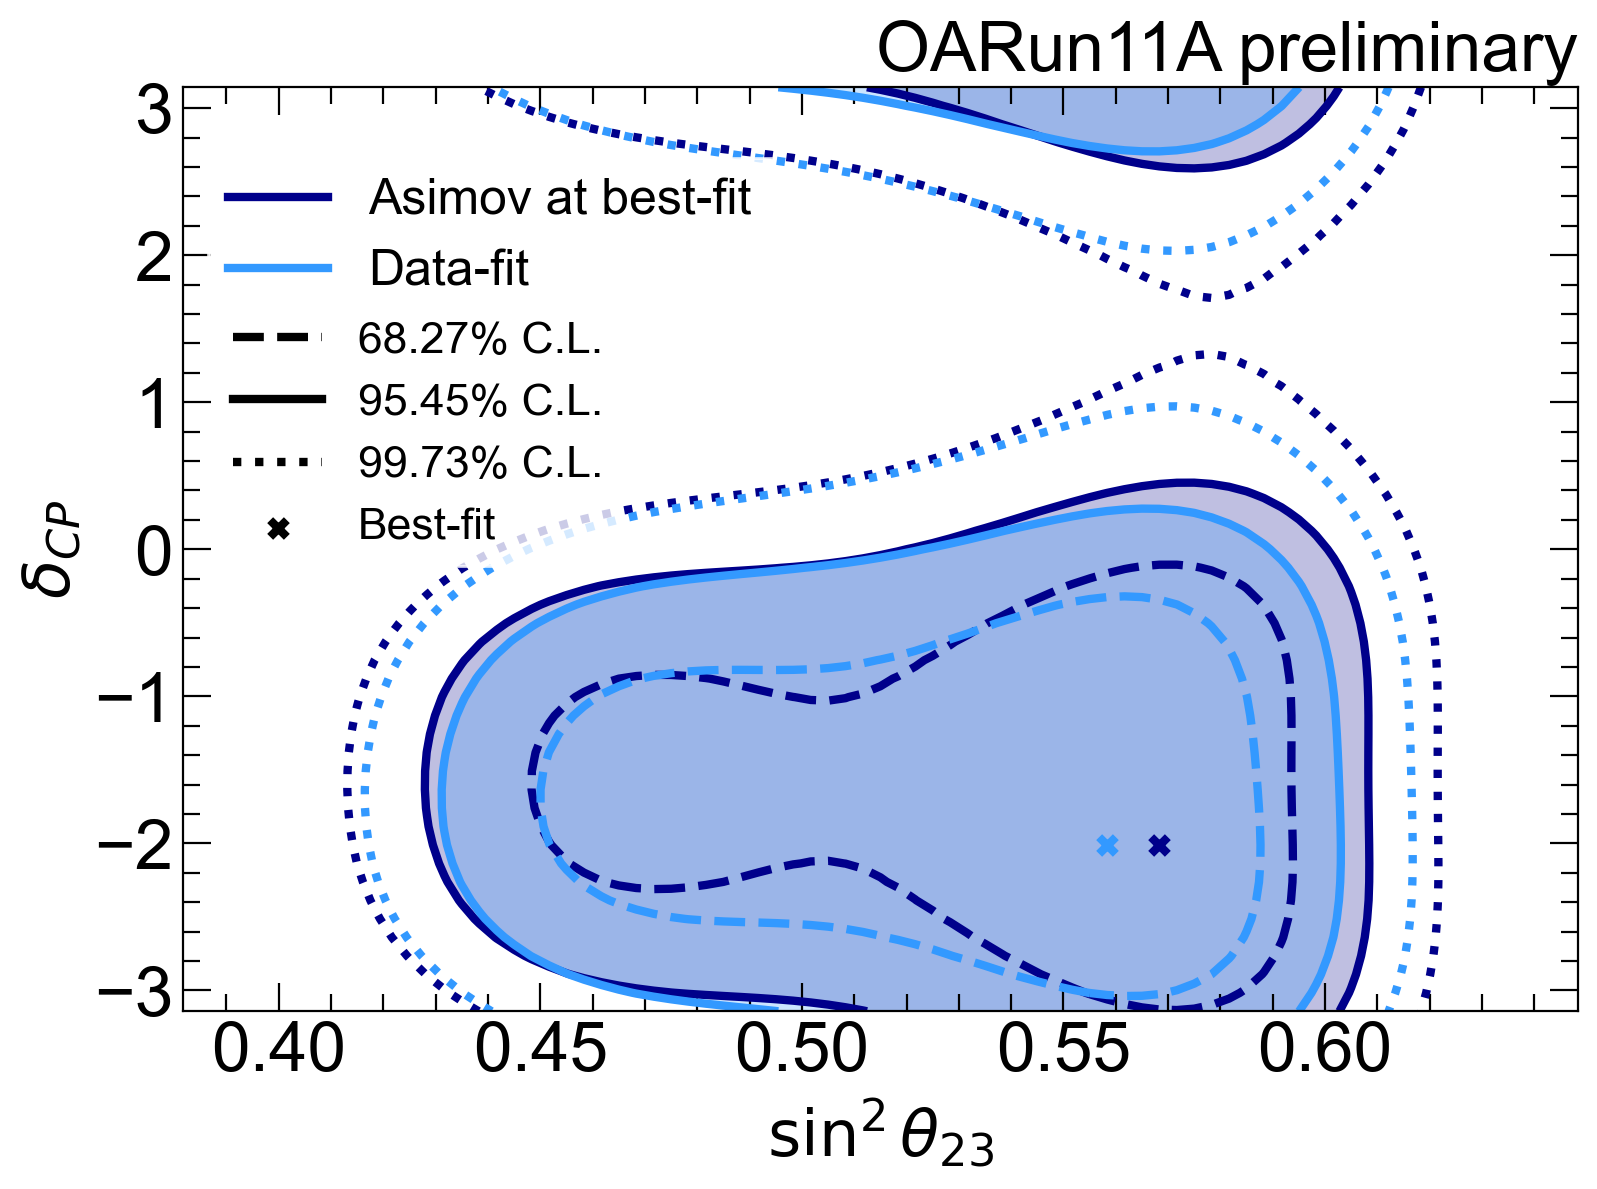

In [6]:
kwargs_bf = {'ax.contour': {0: {'colors': [dfbf_to_color['bestfit'][0]]},
                         1: {'colors': [dfbf_to_color['bestfit'][1]]}},
          'ax.scatter': {0: {'color': [dfbf_to_color['bestfit'][0]]},
                         1: {'color': [dfbf_to_color['bestfit'][1]]}},
         }

kwargs_df = {'ax.contour': {0: {'colors': [dfbf_to_color['datafit'][0]]},
                         1: {'colors': [dfbf_to_color['datafit'][1]]}},
          'ax.scatter': {0: {'color': [dfbf_to_color['datafit'][0]]},
                         1: {'color': [dfbf_to_color['datafit'][1]]}},
         }

mo = 0

fig, ax = plt.subplots()
llh_bf.plot(ax, mo=mo, wtag=False, show_legend=False, **kwargs_bf)
legend_1, legend_2 = llh_df.plot(ax, mo=mo, wtag=True, show_legend=True, **kwargs_df)
param_name_x = llh.param_name[0]

line1, = ax.plot([], [],  label='Asimov at best-fit', color=dfbf_to_color['bestfit'][mo])
line2, = ax.plot([], [],  label='Data-fit', color=dfbf_to_color['datafit'][mo])

ax.legend(handles=[line1, line2], loc='upper left', fontsize=18, bbox_to_anchor=(0, 0.95))
#ax.text(0.65, 0.9, mo_to_label[mo], transform=ax.transAxes, color=color_mo[mo], fontsize=20)

#legend_2.set_loc('center left')  
legend_2.set_bbox_to_anchor((0.33, 0.79))

ax.ticklabel_format(style='scientific', axis='x', scilimits=(-2, 2))


fig.savefig(f"{outdir_path}/dchi2_{param_flattened}_main_bf_vs_df_mo{mo}.eps", bbox_inches='tight')
fig.savefig(f"{outdir_path}/dchi2_{param_flattened}_main_bf_vs_df_mo{mo}.pdf", bbox_inches='tight')
fig.savefig(f"{outdir_path}/dchi2_{param_flattened}_main_bf_vs_df_mo{mo}.png", bbox_inches='tight', dpi=300)
fig.savefig(f"{outdir_path}/dchi2_{param_flattened}_main_bft_vs_df_mo{mo}.svg", bbox_inches='tight')


# Impact of cov. matrices

In [7]:
param_name_x = 'dm2'
prefix = 'DataFit'

if param_name_x == 'dm2':
    filenames = ["contour_dm2_MargTemplates_DataFit_dm2_100k_p-theta_mode_0.root",
                 "contour_dm2_MargTemplates_DataFit_dm2_100k_OA2023_OA2021corr_2_mode_0.root",
                 "contour_dm2_MargTemplates_DataFit_dm2_100k_OA2021_mode_0.root",
                 "contour_dm2_wRC_fullplot_10082022_TNver1XX_DataFit_MRErec.root"]
elif param_name_x == 'delta':
    filenames = ["contour_dCP_SKcov_OA2023.root",
                 "contour_dCP_SKcov_OA2023_0numucc1picorr.root",
                 "contour_dCP_SKcov_OA2021.root",
                 "contour_dCP_wRC_fullplot_10082022_TNver1XX_DataFit_MRErec.root"]
else:
    print('Comparsion only for delta and dm2 is allowed')

llhs = []

lss = ['-', '--', 'dotted', 'dashdot']
labels = ['OARun11A official', 'OARun11A with SKOARun11A(numuCC1pi corr.= 0)', 'OARun11A with SKOARun10B', 'OARun10B official']


for filename in filenames:

    grid, avnllh, param_names = likelihood.load_from_SA(f"{inputs_dir}/{dir_ver}/contours", filename, param_name_x)
    llhs.append(likelihood.Loglikelihood(grid, avnllh, param_names, mo_treat='joint'))


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


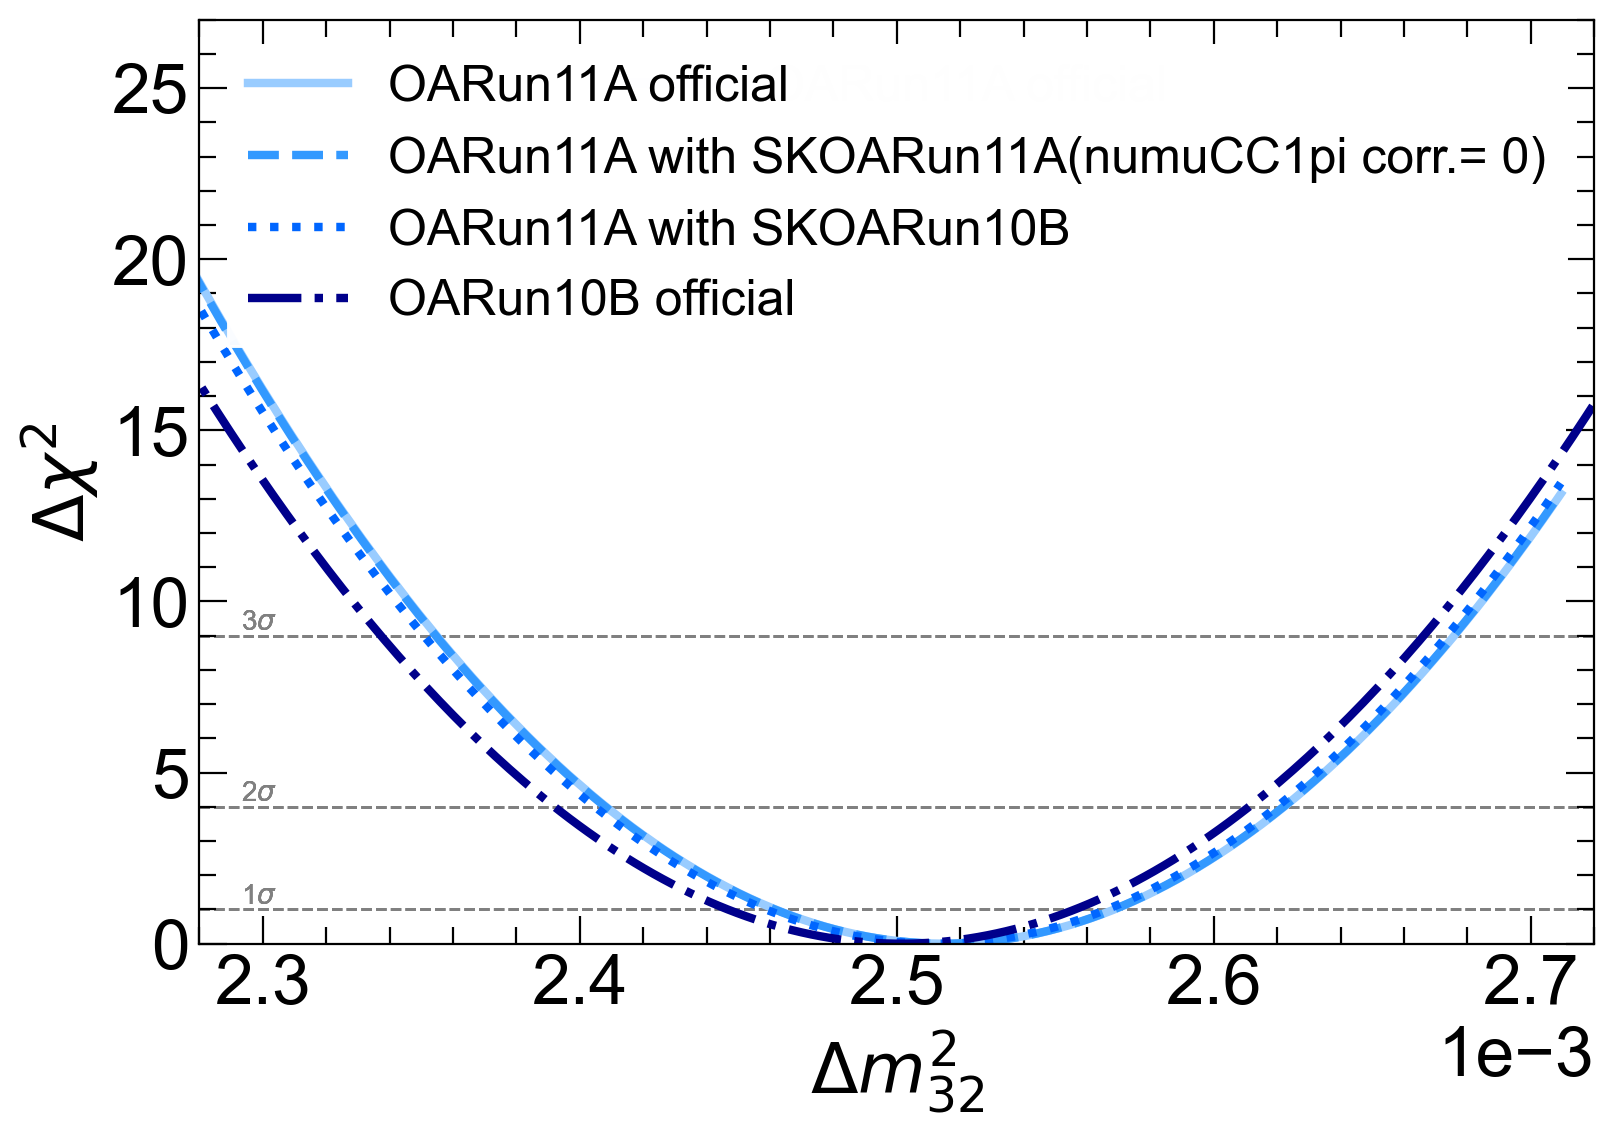

In [8]:
fig, ax = plt.subplots()

params = {'legend.fontsize': 18}
plt.rcParams.update(params)

for i in range(len(llhs)):
    kwargs = { 'ax.plot': {0: {'color': mo_to_colors[0][i], 'label': labels[i], 'ls':lss[i]},
                           1: {'color': mo_to_colors[1][i], 'label': labels[i], 'ls':lss[i]}},
         }
    legend, _ = llhs[i].plot(ax, mo=0, ls=lss[i], **kwargs)

ax.set_ylim(0, 27)


fig.savefig(f"{outdir_path}/dchi2_{param_name_x}_{prefix}_SK_cov_impact.eps", bbox_inches='tight')
fig.savefig(f"{outdir_path}/dchi2_{param_name_x}_{prefix}_SK_cov_impact.pdf", bbox_inches='tight')
fig.savefig(f"{outdir_path}/dchi2_{param_name_x}_{prefix}_SK_cov_impact.png", bbox_inches='tight', dpi=300)
fig.savefig(f"{outdir_path}/dchi2_{param_name_x}_{prefix}_SK_cov_impact.svg", bbox_inches='tight')
